# Logistic Regression

This notebook contains the practical session associated with the [course about classification (en)](doc/Cours_J.Brajard.pdf) given by J.Brajard on Aug. 4th 2016 during the Roscoff Summer School. 

The notebook is based on [the one about logistic regression proposed by J.D. Wittenauer](http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise2.ipynb) which illustrates the corresponding lesson in [Andrew Ng's course (en)](doc/CS229_AndrewNg.pdf). An [exercise text](doc/ex_text.pdf) is also provided.

Other textbook about running a logistic regression with a gradient descent are also available [here](http://online.cambridgecoding.com/notebooks/eWReNYcAfB/implementing-logistic-regression-classifier-trained-by-gradient-descent-4) and [here](http://peterroelants.github.io/posts/neural_network_implementation_part02/).

In this exercise we'll implement logistic regression and apply it to a classification task. We will train the model using different flavors of gradient descent, as explained in [J.Bajard's course](doc/Cours_J.Brajard.pdf) - every reference to *the course* below refers to this one.

Please send me your feedback / remarks: Gilles Moyse <gilles.moyse@lip6.fr>

This notebook can be used and modified freely as long as you mention the author's name and include a link to the original notebook's URL.

## The data

We will build a logistic regression model to predict whether a student gets admitted to a university.  Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression.  For each *training example*, you have the applicant's scores on two exams and the admissions decision.  To accomplish this, we're going to build a classification model that estimates the probability of admission based on the exam scores.

### Examination

Let's start by examining the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
import os
path = 'data' + os.sep + 'LogiReg_data.txt'
pdData = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


How many rows are there? This is computed with the `len` function:

In [3]:
n = len(pdData)
n

100

We have $n=100$ examples made of the 2 exam marks and the same number of labels, 1 or 0, whether the student is admitted (1) or not (0).

### Plot

Let's create a scatter plot of the two scores and use color coding to visualize if the example is positive (admitted) or negative (not admitted).

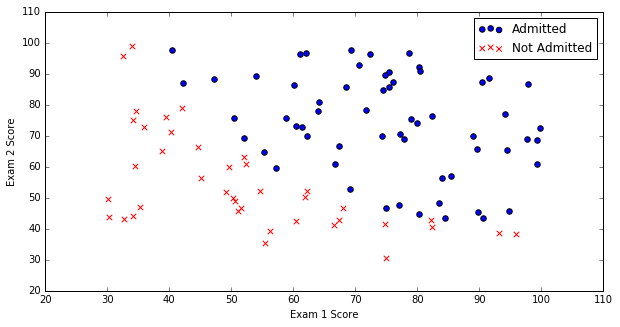

In [4]:
positive = pdData[pdData['Admitted'] == 1] # returns the subset of rows such Admitted = 1, i.e. the set of *positive* examples
negative = pdData[pdData['Admitted'] == 0] # returns the subset of rows such Admitted = 0, i.e. the set of *negative* examples

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

It looks like there is a (more or less) linear decision boundary between the two classes.

## The logistic regression

The goal of this session is to create a classifier or model ($h_\theta$) able to tell us whether a student is to be admitted depending on his/her results.
To do so, we will use the logistic regression classification method. It works by :
1. determining the parameters $\theta$ of the line splitting the data in two groups of similar classes (admitted / not admitted in this example). In our 2 dimensional case, it has the form $\theta_0 + \theta_1 x_1 + \theta_2 x_2$, hence $\theta$ is a 3 dimensions vector made of $\theta_1$, $\theta_2$ and $\theta_3$

2. using this line in a [logistic or sigmoid function](https://en.wikipedia.org/wiki/Logistic_function). This function has the interesting property of projecting any value onto the [0,1] interval, which is desirable in the context of classification between 0 (= not admitted) and 1 classes (= admitted)

3. exploiting the result to predict the student's admissibility: admissible if the previous result is $>0.5$, not admissible otherwise

So as to implement this logic, we define the following functions:
1. `sigmoid` : returns the sigmoid value of an input

2. `model` : returns our model result for a given example

3. `cost` : computes the cost or loss of of our model against the data given the parameters

4. `gradient` : computes the gradient of the loss function for each parameter

5. `descent` : performs a gradient descent to determine the parameters minimizing the loss of our model

6. `accuracy`: computes the model's accuracy

### The `sigmoid` function
See [course p.4](doc/Cours_J.Brajard.pdf#page=6) :

$$
g(z) = \frac{1}{1+e^{-z}}   
$$

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Let's plot it to make sure the function is working.

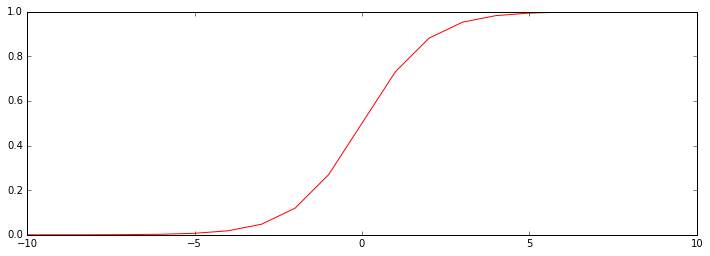

In [6]:
nums = np.arange(-10, 10, step=1) #creates a vector containing 20 equally spaced values from -10 to 10
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(nums, sigmoid(nums), 'r')

Note some interesting properties of the sigmoid function $g$:
* $g:\mathbb{R} \to [0,1]$
* $g(0)=0.5$
* $g(- \infty)=0$
* $g(+ \infty)=1$

### The `model` function
Based on the sigmoid function, our *model* $h_\theta$ is defined by ([course p.4](doc/Cours_J.Brajard.pdf#page=6)):
$$
h_\theta(x) = g(\theta^T x)
$$

The model is composed of 2 parts :
* $\theta^Tx$ is the distance between $x$, the 2 dimensional point made of the 2 exam results $(x_1,x_2)$ and the line $\theta^T x=0$, equivalently written $\theta_0+\theta_1 x_1 + \theta_2 x_2=0$ in a non matrix notation.  
We want this line to clearly separate the points of class 0 (not admitted) from those of class 1 (admitted). This way, if $\theta^T x>0$, i.e. if the point $x$ is "on the right" of the line, then it belongs to the group of admitted students, and we can label it 1. Otherwise, $\theta^T x<0$, so the point is "on the left" of the line and the student belongs to the class 0 (not admitted).  
In the particular case where $\theta^Tx=0$, i.e. $x$ is located on the line, the point is arbitrarily classified (1 for instance).
* The second part of the model corresponds to the application of the sigmoid function to the distance $\theta^Tx$ just computed. 
This function allows us to have a result in [0,1] and hence to interpret it as a probability. It should actually rather be seen as a kind of *confidence* score since the farther $x$ is on the right side of the line, the higher the value of $\theta^Tx$, the closer to 1 the sigmoid result and the more certain we are that the student is admitted (class 1) . The same reasoning applies if the point is far on the left and the result is close to 0. If the point is close to the line though, then the sigmoid result is close to 0.5 and the confidence in attributing the class 0 or 1 to the point is smaller. The most uncertain case happens if $x$ lies on the separation line.
* Finally, the result is compared to 0.5 and the class 0 is returned if $g(\theta^Tx)<0.5$ and the class 1 otherwise.  
Note that the `model` function does not perform this last comparison step which is done later at classification time.

As a last comment, please note the line model $\theta^Tx$ we're using here contains 3 parameters, $\theta_0$, $\theta_1$, $\theta_2$, as opposed to the one we used for linear regression in the previous session, which used only the 2 parameters $\theta_0$ and $\theta_1$. Why ?

The most general model for a line actually uses 3 parameters, 1 for the slope of each axis $x_1$ and $x_2$ and one for an offset value. This model, $\theta_0+\theta_1x_1+\theta_2x_2$, can represent any kind of line. Since the line used to separate the positive (1) from the negative (0) examples can be of any kind, we use this most general model.

In the linear regression, the line model we use $y=\theta_1x+\theta_0$ is slightly less general and cannot represent vertical lines. But it is well suited to the purpose of linear regression, i.e. finding a relation between the $x$ and $y$ values. A vertical line, which can also be seen as an horizontal one if we swap the dimensions, simply indicates the absence of linear relation between $x$ and $y$, which precisely means that it cannot be expressed as $y=\theta_1x+\theta_0$.

So the line model we use here for logistic regression is the most general one, based on 3 parameters, thus $p=3$. This value is used in the comments of the `model` function below since the formula in the implementation is adapted to take into account the matrices and vectors' dimension. 

In [7]:
def model(X, theta):
    """ Returns our model result
    :param X: examples to classify, n x p
    :param theta: parameters, 1 x p
    :return: the sigmoid evaluated for each examples in X given parameters theta as a n x 1 vector
    """
    return sigmoid(np.dot(X, theta.T))

As we can see from the previous function, $X$ is a $n\times p$ matrix. However, the data contains only 2 values for each example, corresponding to the marks obtained in the 2 exams. In fact, as in the previous session, we add a column of 1 as the first dimension of the data in order to unify the operations. By setting $x_0=1$, we have
$$
\begin{array}{ccc}
\begin{pmatrix}\theta_{0} & \theta_{1} & \theta_{2}\end{pmatrix} & \times & \begin{pmatrix}1\\
x_{1}\\
x_{2}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$$
which is precisely the model we are trying to fit.

We will create $X$, $y$ and $\theta$ right now :

In [8]:
try:
    pdData.insert(0, 'Ones', 1) # in a try / except structure so as not to return an error if the block si executed several times
except:
    pass

# set X (training data) and y (target variable)
orig_data = pdData.as_matrix() # convert the Pandas representation of the data to an array useful for further computations
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
#X = np.matrix(X.values)
#y = np.matrix(data.iloc[:,3:4].values) #np.array(y.values)
theta = np.zeros([1, 3])

Let's quickly check the shape of our arrays to make sure everything looks good.

In [9]:
X.shape, y.shape, theta.shape

((100L, 3L), (100L, 1L), (1L, 3L))

That is fine : $X$ is the $n\times p$ examples matrix, $y$ the $n\times 1$ labels vector and $\theta$ the $1\times p$ parameters vector.

### The `cost` function
The *cost* or *loss* of an individual example $x$ measures the classification error done with our model given the true answer $y$ which can be 0 (not admitted) or 1 (admitted).
The cost is 0 if it correctly classifies $x$, i.e. returns a result equal to $y$.

The cost function is used in the gradient descent algorithms (see later). For the logistic regression, it is given by ([course p.12](doc/Cours_J.Brajard.pdf#page=21)):

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$

The above formula allows the cost computation for a single example, but it can be computed for several examples at once with the matrix implementation of the function. In this case, $X$ is a $n\times p$ matrix containing the $n$ examples in $p$ dimensions, $y$ is a $n\times 1$ vector and $\theta$ is the $1\times p$ vector containing the model's parameters.  
Moreover, the cost function for several examples averages each individual example's cost. The average is used instead of a mere sum so as to allow the comparison of the costs of datasets not having the same size.  
Hence the cost function $J$ is defined as ([course p.9](doc/Cours_J.Brajard.pdf#page=16)):
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In terms of implementation, the python function computes $D(h_\theta(x), y)$ for each individual examples in $X$ by multiplying element wise $y$ with $\log(h_\theta)$ for the left part and $1-y$ with $1-\log(h_\theta(x))$ for the right one and then computing the average value of the obtained vector.

In [10]:
def cost(X, y, theta):
    """
    Computes the cost of classifying y with our model
    :param X: examples to clasify, n x p matrix
    :param y: labels/classes, n x 1 vector
    :param theta: model's parameters, 1 x p vector
    :return: our model's prediction for each example, n x 1 vector
    """
    #import pdb; pdb.set_trace(); # uncomment this to debug
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))

Now let's compute the cost for our initial solution (0 values for theta).

In [11]:
cost(X, y, theta)

0.69314718055994529

### The `gradient` function
Now we can compute the model's prediction and its corresponding cost, we will try to find the parameters minimizing this cost. We assume that these parameters will also be relevant with further unseen data.

We will determine them using the *gradient descent* method. The principle of this approach is to explore the space defined by the cost function (here a 4 dimensional one since we have 3 parameters) going step by step in the direction of the steepest descent. This direction is given by the opposite of its gradient, i.e. the derivative over each of its parameters.

The gradient of the cost function is ([course p.14](doc/Cours_J.Brajard.pdf#page=26)):
$$
\nabla J(\theta) = \begin{pmatrix}
\frac{\partial J}{\partial \theta_1} \\
... \\
\frac{\partial J}{\partial \theta_p} \\
\end{pmatrix}
$$

In our case, since we have only three parameters, the gradient is:
$$
\nabla J(\theta) = \begin{pmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\end{pmatrix}
$$

Since the gradient indicates the direction of increasing values, we use its opposite in order to find the smallest cost.

Deriving the expression of the cost function $J(\theta)$ detailed earlier, we find that the gradient of the cost function of the logistic regression is the same than the one we used for the linear regression in the previous session. Indeed ([course p.14](doc/tp4_0_cours_J.Brajard.pdf#page=26)) :

$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$

In python now:

In [12]:
def gradient(X, y, theta):
    """
    Computes the gradient
    :param X: n x p matrix containing the examples
    :param y: n x 1 vector containing the labels
    :param theta: 1 x p vector containing the parameters
    :return: 1 x p vector containing the gradients
    """
    #import pdb; pdb.set_trace() # uncomment this to debug
    grad = np.zeros(theta.shape)
    error = (model(X, theta)- y).ravel()
    for j in range(len(theta.ravel())): #for each parmeter
        term = np.multiply(error, X[:,j])
        grad[0, j] = np.sum(term) / len(X)
    
    return grad

### Gradient descent

We are now ready to run the optimization and find the best parameters by repeatedly updating them in the opposite direction returned by the gradient. This process is called *gradient descent*.

At each *iteration*, we use a given number of example data 

Several variants of the gradient descent exist, depending on:
* the **number of examples** used at each iteration:
 * 1 example $\to$ *stochastic* descent ([course p.19](doc/Cours_J.Brajard.pdf#page=36))
 * $(1,n)$ examples $\to$ *mini batch* descent ([course p.21](doc/Cours_J.Brajard.pdf#page=39))
 * $n$ (all) examples $\to$ *gradient* descent ([course p.18](doc/Cours_J.Brajard.pdf#page=35))

* the **stopping criterion** deciding when to stop the descent algorithm:
 * after a given number of iterations
 * when the difference between two successive costs is lower than a threshold
 * when the norm of the gradient vector is lower than a threshold

* the **learning rate** ([course p.18](doc/Cours_J.Brajard.pdf#page=35)):
 * constant
 * variable

We will develop in the following a generic gradient descent method allowing to compare its variants except for the learning rate which we will not adapt automatically but rather manually.

#### `showDescentProgess`
This function in mainly designed for debug purposes. It displays the gradient descent's progress.

In [13]:
DEBUG = False
np.set_printoptions(precision=3)

def showDescentProgress(i, grad, theta, costs):
    """
    Stopping function to be used with batchDescent
    Stops when after a given number of iterations
    """
    if DEBUG: print  i, "* Grad",  grad, "* Theta", theta, "* Cost", costs[-1]

#### `stopCriterion`
This function implements the different stopping criterion presented earlier.

In [14]:
#Constants used to define the kind of stopping criterion
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    """
    Returns true/false whether the stop criterion is reached or not
    :param type: type of criterion
                    - STOP_ITER : stops if the number of iterations is grater than the threshold
                    - STOP_COST : stops if the difference between 2 successive costs is below the threshold
                    - STOP_GRAD : stops if the norm of the gradient is below the threshold
    :param value: value needed for the test
                    - STOP_ITER : current iteration number
                    - STOP_COST : costs list
                    - STOP_GRAD : gradient vector
    :param threshold: threshold used depending on the method
    :return: true if the stopping criterion is satisfied, false otherwise
    """
    if type == STOP_ITER:        return value > threshold
    elif type == STOP_COST:      return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      return np.linalg.norm(value) < threshold

#### `shuffleData`
This function is used for the stochastic and mini batch variants. In these cases indeed, the examples need to shuffled before being progressively used for the descent, otherwise successive run through the dataset are equivalent.
Hence the function first shuffles the dataset and reinitializes the $X$ and $y$ variables accordingly.

In [15]:
import numpy.random

def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

#### `descent`
This function actually performs the gradient descent. The $\theta$ parameter is required as input so as to repeatedly call the `descent` function with different parameters, thus allowing to fine tune the learning rate manually while keeping the optimization performed in the previous calls.

In [16]:
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    """
    Runs the gradient descent in batch mode
    :param data: original data, to be shuffled
    :param y: n x 1 labels vector
    :param theta: 1 x p parameters vector - may be zeros
    :param batchSize: number of examples to consider at each step - 1 for stochastic, n for batch, and any other value for mini batch
    :param stopType: stopping criterion in STOP_ITER, STOP_COST, STOP_GRAD
    :param thresh: value used for the stopping criterion
    :param alpha: learning rate, real value
    :return: (theta, iterations, costs, gradient)
        theta: 1 x p parameters vector
        iterations : number of iterations done
        costs: list containing the cost of the model at each iteration
        gradient: last gradient computed
        time: the time spent doing the descent
    """
    #import pdb; pdb.set_trace();
    init_time = time.time()
    i = 0 # iteration number
    k = 0 # batch counter to loop through data
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape) # gradient computed at each iteration
    costs = [cost(X, y, theta)] # init costs with initial cost
    #showDescentProgress(i, grad, theta, costs)
    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)# computes the gradient
        k += batchSize # increase the index in the data
        if k >= n: # if the whole dataset has been scanned
            k = 0 # reset the data counter
            X, y = shuffleData(data) # start a new epoch on shuffled data      
        theta = theta - alpha*grad # adjust the parameters based on the computed gradient
        costs.append(cost(X, y, theta)) # compute the new cost and add it to the list
        i += 1 # increase iteration number
        #showDescentProgress(i, grad, theta, costs)
        # evaluate the stopping criterion
        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

#### `runExpe`
Runs an experiment and return results in order to compare the different methods

In [17]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print "***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

### Comparison of the stopping criterions

#### Stopping on iterations

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.     0.007  0.004]] - Iter: 5000 - Last cost: 0.63 - Duration: 1.01s


array([[-0.   ,  0.007,  0.004]])

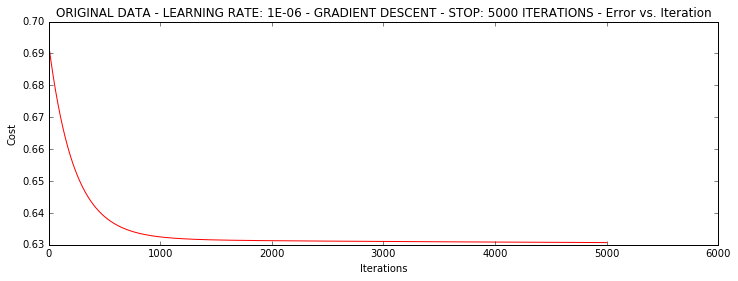

In [18]:
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

#### Stopping on cost

With a threshold of 1E-6, almost 110 000 iterations are needed... (~18 seconds on my computer)

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.134  0.048  0.041]] - Iter: 109901 - Last cost: 0.38 - Duration: 21.31s


array([[-5.134,  0.048,  0.041]])

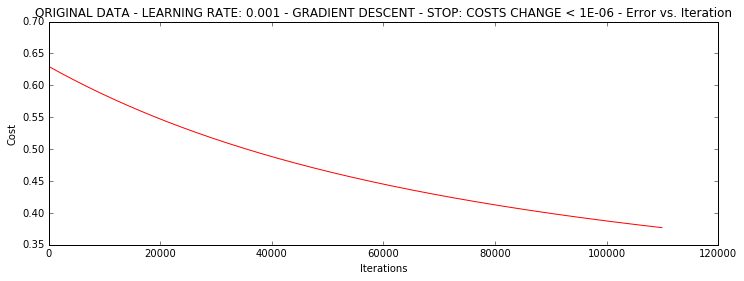

In [19]:
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

#### Stopping on gradient norm

With a threshold of 0.05, a bit more than 40 000 iterations are needed... (~7 seconds on my computer)

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37   0.027  0.019]] - Iter: 40045 - Last cost: 0.49 - Duration: 8.00s


array([[-2.37 ,  0.027,  0.019]])

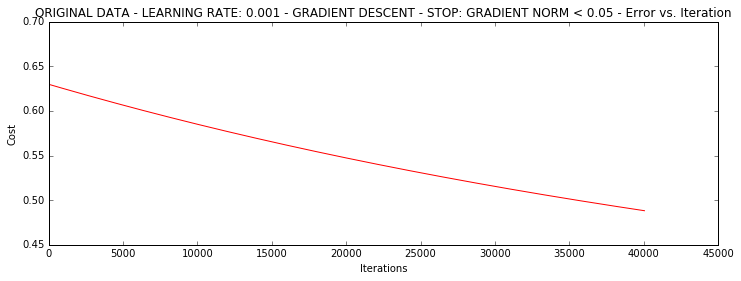

In [20]:
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

The graphs above seem to show that we could continue the descent in order to further reduce the cost. Instead of adding more iterations, let us see if the different types of descent might help reaching the minimum in a faster way.

### Comparison of the types of descent

Here, we will compare the stochastic and mini batch descent with the batch one we have just tried earlier. We will use 5000 iterations.

#### Stochastic descent

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.389  0.072  0.062]] - Iter: 5000 - Last cost: 2.70 - Duration: 0.40s


array([[-0.389,  0.072,  0.062]])

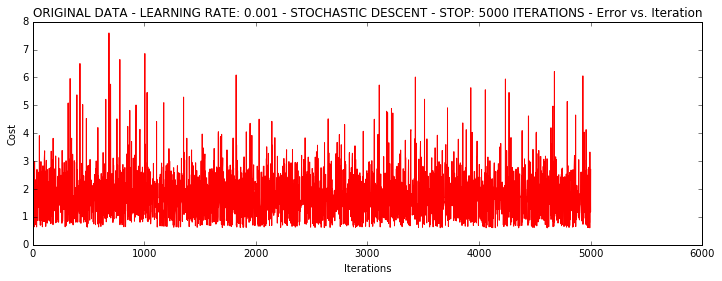

In [21]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

The algorithm diverges, since the learning rate is too high for a stochastic descent. Let us try a smaller value.

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 15000 iterations
Theta: [[-0.002  0.01   0.001]] - Iter: 15000 - Last cost: 0.63 - Duration: 1.07s


array([[-0.002,  0.01 ,  0.001]])

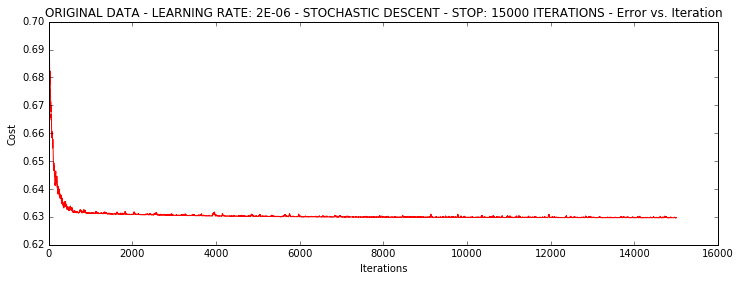

In [22]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

It seems we cannot go below the 0.63 cost with stochastic descent. Apprently, increasing the number of iterations will not improve the situation.

In comparison, batch descent with 5000 iterations was able to reach 0.61 and adding iterations allowed to reduce the value, as shown in the experiments with the *cost* and *gradient norm* stopping criterions.

Let us now try the mini-batch descent.

#### Mini-batch descent

***Original data - learning rate: 0.001 - Mini-batch (50) descent - Stop: 15000 iterations
Theta: [[-1.009  0.017  0.006]] - Iter: 15000 - Last cost: 0.57 - Duration: 1.86s


array([[-1.009,  0.017,  0.006]])

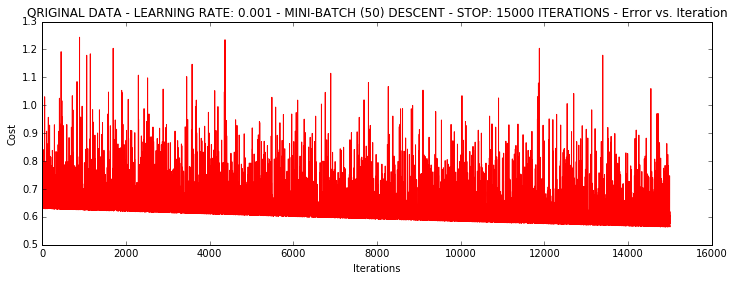

In [23]:
runExpe(orig_data, theta, n/2, STOP_ITER, thresh=15000, alpha=0.001)

This is a bit better, but not satisfactory yet...

We will now try descending with scaled data.

### Scaling the data  ([course p.17](doc/Cours_J.Brajard.pdf#page=34))

The scaling we use here consists of substracting the dataset mean to each point and dividing it by the dataset standard deviation.

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[ 0.308  0.865  0.774]] - Iter: 5000 - Last cost: 0.38 - Duration: 0.92s


array([[ 0.308,  0.865,  0.774]])

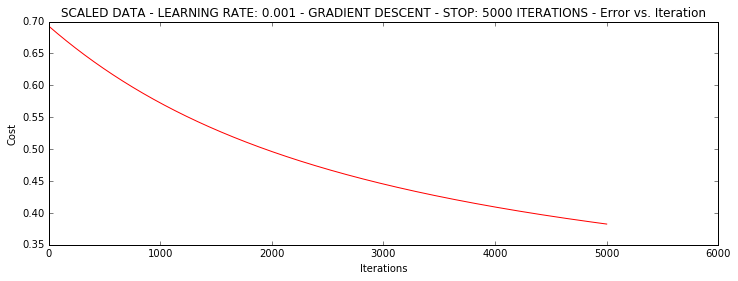

In [24]:
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])

runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

It is much better! With the unscaled data, we reached 0.61 after 5000 iterations, wehereas we obtain 0.38 here!

Instead of trying to guess the correct number of iterations, we will run the experiment again with a stopping criterion based on the gradient norm.

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.02
Theta: [[ 1.071  2.63   2.411]] - Iter: 59422 - Last cost: 0.22 - Duration: 12.00s


array([[ 1.071,  2.63 ,  2.411]])

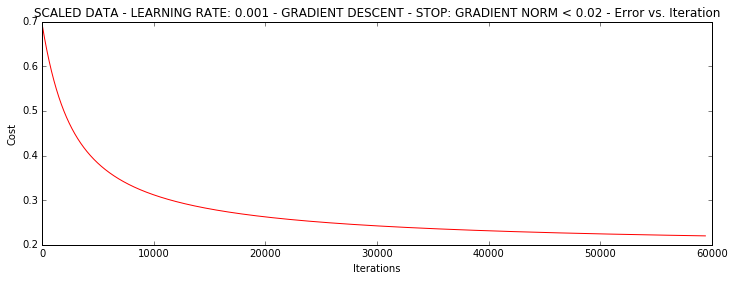

In [25]:
runExpe(scaled_data, theta, n, STOP_GRAD, thresh=0.02, alpha=0.001)

It seems we have found the minima! The cost is 0.21 after 112 000 iterations!
For comparison, let us see how stochastic and mini-batch descents behave here.

***Scaled data - learning rate: 0.001 - Stochastic descent - Stop: gradient norm < 0.0004
Theta: [[ 1.147  2.794  2.565]] - Iter: 72610 - Last cost: 0.22 - Duration: 5.93s


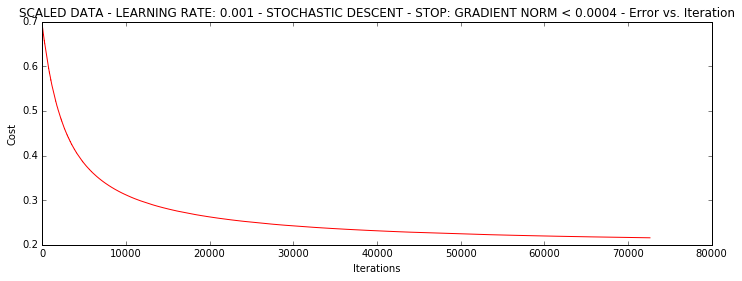

In [26]:
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.002/5, alpha=0.001)

Stochastic descent is much faster since a similar cost value is reached in ~6s vs ~12s with batch descent. Please note that the threshold based on gradient norm is 5 times smaller with the stochastic descent than with the batch one.

What about mini-batch now?

***Scaled data - learning rate: 0.001 - Mini-batch (50) descent - Stop: gradient norm < 0.004
Theta: [[ 1.162  2.824  2.595]] - Iter: 2758 - Last cost: 0.21 - Duration: 0.50s


array([[ 1.162,  2.824,  2.595]])

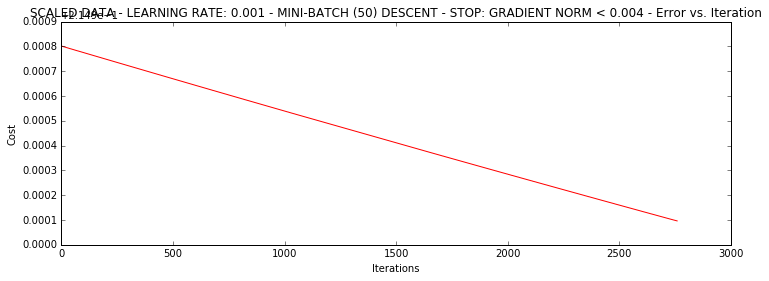

In [27]:
runExpe(scaled_data, theta, n/2, STOP_GRAD, thresh=0.002*2, alpha=0.001)

The result is in-between : faster than batch but slower than stochastic for a similar final cost.

In every case, you can note that the parameters are pretty different though having the same cost. This is due to the fact that the space we are exploring is quadratic (see [Andrew Ng's course bottom of p.5](doc/CS229_AndrewNg.pdf#5)), hence there is a circle made of different parameters values having the same cost. The circle becomes smaller and smaller until it becomes a point, corresponding to the minimum.

## Classifier accuracy
We will now evaluate the accuracy of our classifier. The accuracy is one of the simplest measure for a classifier. Others can be used, as [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)...As often, the Wikipedia pages for these measures are a good start. For a more advanced treatment about them, you can look at [this paper](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf).

Regarding accuracy, it is simply the proportion of correctly classified examples. It is based on a *prediction* function: if the classifier returns a value lower than 0.5 then the result is 0 (not admitted) otherwise it is 1 (admitted).

In [28]:
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

Next we need to write a function that will output predictions for a dataset X using our learned parameters theta.  We can then use this function to score the training accuracy of our classifier.

In [29]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print 'accuracy = {0}%'.format(accuracy)

accuracy = 89%


Our logistic regression classifier correctly predicted if a student was admitted or not 89% of the time.  Not bad!  Keep in mind that this is training set accuracy though.  We didn't keep a hold-out set or use cross-validation to get a true approximation of the accuracy so this number is likely higher than its true performance.

Using training, validation and test sets to measure a classifier's performance is off-scope here. The interested reader may refer to the chapter 5.2 p.110 in *Goodfellow, I., Y. Bengio, and A. Courville,* [Deep Learning](doc/DeepLearning_Chap5.pdf#13)